<ipython-input-81-cf129d911b21>:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
<ipython-input-81-cf129d911b21>:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(custom_labels)


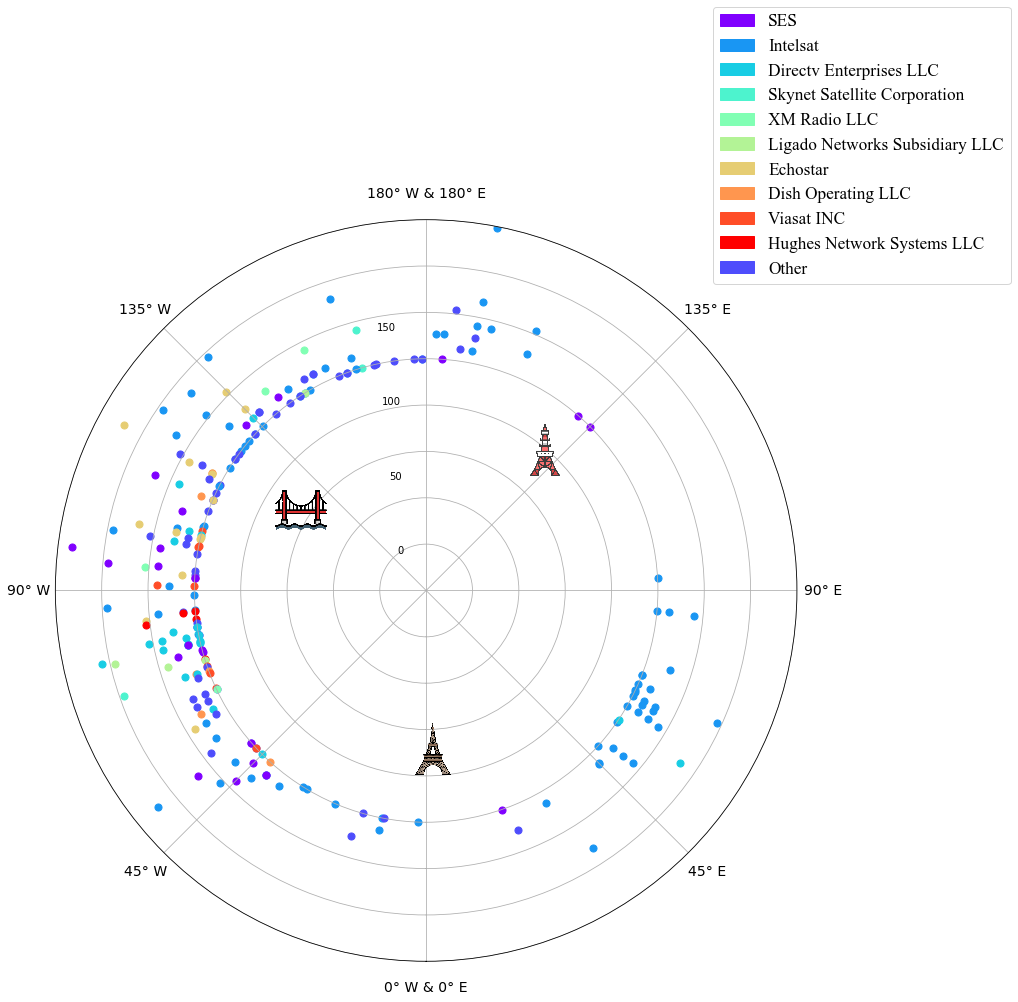

In [81]:
from matplotlib.offsetbox import OffsetImage # Overlays images, like the Golden Gate Bridge, on the plot with specific coordinates
from matplotlib.patches import Circle # Creates a clipping path for the images, like the Golden Gate Bridge. Clipping paths, depending on their shape keep everything within that shape inside the clipping.
from matplotlib.transforms import blended_transform_factory # Useful for mixing multiple coordinate systems together. In this case, it's helpful to place custom y-axis labels on the plot. 

df = pd.read_csv('/Users/zaynpatel/FCCDataCleaning/FCCDataCleaning/loc_freq_GSO_files.csv.csv') # import the CSV which has the longitude of GSO orbits
df = df.dropna(subset=['orbitdegree', 'orbitlongitude']) # drop rows with no orbit degree or longitude 

# Add 180 to 'orbitdegree' if 'orbitlongitude' is 'W' - necessary to transform West values so they can be graphed
df['orbitdegree'] = df.apply(lambda row: row['orbitdegree'] + 180 if row['orbitlongitude'] == 'W' else row['orbitdegree'], axis=1)

# select 'File.Number', 'orbitdegree', and 'Applicant.Name_TABLE', and drop duplicates
# drop.duplicates() is the same as .distinct() in R - I wanted to get rid of all duplicates across these three categories
# also, the double list syntax here is similar to the select() syntax in R
unique_df = df[['File.Number', 'orbitdegree', 'Applicant.Name_TABLE']].drop_duplicates()

# Get the top 10 companies by count
top_companies = unique_df['Applicant.Name_TABLE'].value_counts().index[:10]

# Create a new column 'Company' where companies not in the top 10 are replaced by 'Other' - 
unique_df['Company'] = [name if name in top_companies else 'Other' for name in unique_df['Applicant.Name_TABLE']]

# Count the number of unique 'File.Number' for each 'orbitdegree' and 'Company'
count_df = unique_df.groupby(['orbitdegree', 'Company']).count().reset_index()

# Normalize the counts for plotting so there was consistency in plotting. All dots are interpreted relative to each other with no outliers. 
# The normalization that's happening here is on the filenumber count
max_n = count_df['File.Number'].max()
min_n = count_df['File.Number'].min()
count_df['norm_n'] = (count_df['File.Number'] - min_n) / (max_n - min_n) * 10

# Cap 'norm_n' at 10
count_df['norm_n'] = count_df['norm_n'].apply(lambda x: 20 if x > 20 else x)

# Convert 'orbitdegree' to to numeric type for plotting (it was a str in the df)
count_df['orbitdegree'] = pd.to_numeric(count_df['orbitdegree'])

# Create a new column for plotting
count_df['orbitdegree_rad'] = np.deg2rad(count_df['orbitdegree']) # convert to radians for the radial plot
company_names = count_df['Company'].unique() # only extract company names that aren't repeated twice
colors = plt.cm.rainbow(np.linspace(0, 1, len(company_names))) # create an array of equally spaced numbers between 0 and 1, # of elements in array is len(company_names) and uses the c.mrainbow to correspond to an array of colors in rainbow spectrum
color_map = dict(zip(company_names, colors)) # creates a mapping between company names and colors

# Create the plot
plt.figure(figsize=(16, 16))
ax = plt.subplot(polar=True)

# Offset the plot from 0, where the Earth is located
count_df['norm_n'] += 5

# for loop is used to plot all points - iterates through the df with counts of the values and uses loc to fetch the value in the columns mentioned
# note: .loc is for label-based indexing with rows/columns; .iloc is used for integer based indexing to select index of rows or columns
for i in range(len(count_df)):
    ax.scatter(count_df.loc[i, 'orbitdegree_rad'], count_df.loc[i, 'norm_n'], c=[color_map[count_df.loc[i, 'Company']]], s=50)

# in order to plot images, I needed to show their coordinates and provide the path to an image
# the math behind coords for Golden Gate Bridge is: 360 - original longitude = new longitude (this new longitude is on a 360 scale)
# the subtraction from 360 is only necessary for Western Hemisphere longitudes since those are sometimes represented on a -180 to 180 scale where their values are negative
landmarks = {
    'Golden Gate Bridge': {
        # longitude, latitude, adjustment is the structure of this code
        'coords': (360 - 122.4783, 37.8199 / 90 * 10 - 1),
        'img_path': '/Users/zaynpatel/Desktop/golden-gate-bridge.png'
    },
    'Tokyo Tower': {
        'coords': (139.7454, 35.6586 / 90 * 10),
        'img_path': '/Users/zaynpatel/Desktop/tokyo.png'
    },
    'Eiffel Tower': {
        'coords': (2.2945, (48.8584 / 90 * 10) - 2),
        'img_path': '/Users/zaynpatel/Desktop/eiffel-tower.png'
    },
}

for name, landmark in landmarks.items():
    img = plt.imread(landmark['img_path']) # reads an image, the output is a numpy array that represents the image in terms of pixel values
    img = OffsetImage(img, zoom=0.1)  # OffsetImage() is used to place the image on the plot
    img.image.axes = ax 
    patch = Circle((0,0), radius=0.5, facecolor='none', edgecolor='none') # set a clipping path
    img.set_clip_path(patch)
    theta, r = landmark['coords'] # polar coordinates
    theta_rad = np.deg2rad(theta)
    ab = AnnotationBbox(img, (theta_rad, r), frameon=False) # AnnotationBbox is important to contain the image so it can be added to the plot
    ax.add_artist(ab)
    
# Customize the plot
ax.set_theta_zero_location("S")
ax.set_theta_direction(1)
# Make the y-axis visible
ax.get_yaxis().set_visible(True)

# Set the limits of the y-axis
ax.set_ylim([0, 8])

# custom labels for the y axis based on the total number of filings in the region
custom_labels = ["", "", "", "", 0, 50, 100, 150]
labels = [
    '0° W & 0° E', '45° E', '90° E', '135° E', '180° W & 180° E', '135° W', '90° W', '45° W'
]
ax.set_xticklabels(labels)

ax.tick_params(axis='x', pad=16)

ax.set_yticklabels(custom_labels)

# Remove existing y-axis labels
ax.set_yticklabels([])

trans = blended_transform_factory(ax.transData, ax.transAxes)

# structure is (x_coord in polar coordinates, y_coord in polar, data point, share how data points should be transformed)
ax.text(67.5, 0.55, '0', transform=trans, horizontalalignment='center')
ax.text(67.5, 0.65, '50', transform=trans, horizontalalignment='center')
ax.text(67.5, 0.75, '100', transform=trans, horizontalalignment='center')
ax.text(67.5, 0.85, '150', transform=trans, horizontalalignment='center')

# Increase the size of the degree markers
ax.tick_params(axis='x', labelsize=14)

# Get the list of companies excluding 'Other'
companies_excluding_other = [name for name in company_names if name != 'Other']

# Create legend elements for these companies
legend_elements = [Patch(facecolor=color_map[name], edgecolor=color_map[name], label=name) for name in companies_excluding_other]

# Add 'Other' to the end
legend_elements.append(Patch(facecolor=color_map['Other'], edgecolor=color_map['Other'], label='Other'))

# Set the font for legend
font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_size('xx-large')

# Add the legend to the plot
ax.legend(handles=legend_elements, loc='right', bbox_to_anchor=(1.3, 1.1), prop=font)

# legend was bleeding off figure; added this so everything was fit to the figure space
plt.tight_layout()

# Save the figure to a file
plt.savefig('radial_test.jpeg', format='jpeg', dpi=300)

# Show the plot
plt.show()